In [95]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics

In [175]:
l = [file_name for file_name in os.listdir() if os.path.splitext(file_name)[1] == '.pickle']
groups = 2

base = pd.concat([pd.read_pickle(path) for path in l], axis=0)
base = base[base['l'].apply(lambda x: (x!=0).all())].reset_index(drop=True)

for col in ['sol', 'sol_gov']:
    base = pd.concat([base.drop(col, axis=1), pd.json_normalize(base[col]).add_suffix('_' + col)], axis=1)
    
for col in ['cost_sol', 'cost_sol_gov']:
    base[col] = base[col].apply(lambda x: x.flatten())
    base[col] = pd.DataFrame(base[col].to_list()).sum(axis=1)
    
base[['d_11', 'd_12', 'd_21', 'd_22']] = pd.DataFrame(np.array(base['d'].to_list()).reshape(base.shape[0], groups**2))
base[['l_1', 'l_2']] = pd.DataFrame(np.array(base['l'].to_list()).reshape(base.shape[0], groups))

base['sol_gap'] = base['cost_sol'] - base['cost_sol_gov']

base['best_sol'] = base.apply(lambda row: 'gov' if row['cost_sol_gov'] < row['cost_sol'] else 'game', axis=1)


In [176]:
base['d_between'] = 0
base['d_within'] = 0
for p in range(1,groups+1):
    base.eval(f'd_{p} = d_{p}1 + d_{p}2', inplace=True)
    for p2 in range(1,groups+1):
        if p == p2:
            base['d_between'] += base[f'd_{p}{p2}']
        else:
            base['d_within'] += base[f'd_{p}{p2}']

base['l_rate'] = base['l_1'] / base['l_2']
        

In [177]:
base[['d_11', 'd_12', 'd_21', 'd_22']].sum(axis=1)

0        0.333098
1        0.253309
2        0.468736
3        0.621143
4        0.691815
           ...   
10974    0.357703
10975    0.338511
10976    0.242001
10977    0.332919
10978    0.248688
Length: 10979, dtype: float64

In [178]:
params = ['T', 'I0', 'd', 'l']

In [179]:
base.columns

Index(['T', 'I0', 'd', 'l', 'Recovered_rate', 'ReSusceptible_rate', 'time',
       'v_sol', 'v_der_sol', 'cost_sol', 'msg_sol', 'test_results.derv_sol',
       'test_results.cost_derv_sol', 'test_results.solution_sol', 'v_sol_gov',
       'v_der_sol_gov', 'cost_sol_gov', 'msg_sol_gov',
       'test_results.derv_sol_gov', 'test_results.cost_derv_sol_gov',
       'test_results.solution_sol_gov', 'd_11', 'd_12', 'd_21', 'd_22', 'l_1',
       'l_2', 'sol_gap', 'best_sol', 'd_between', 'd_within', 'd_1', 'd_2',
       'l_rate'],
      dtype='object')

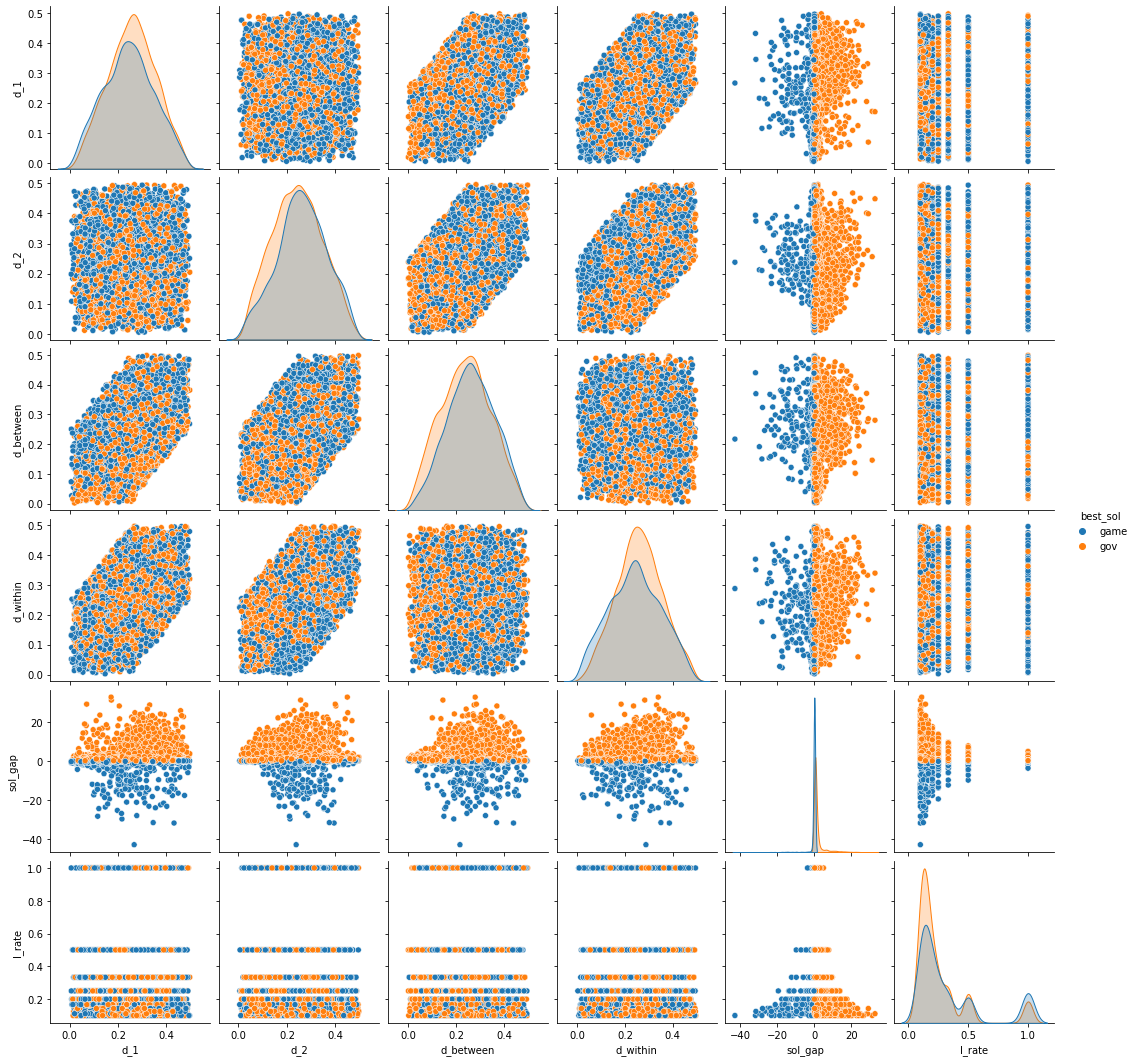

In [180]:
columns = ['d_1', 'd_2', 'd_between', 'd_within', 'best_sol', 'sol_gap', 'l_rate']
sns.pairplot(base[columns], hue='best_sol')

<AxesSubplot:xlabel='T', ylabel='sol_gap'>

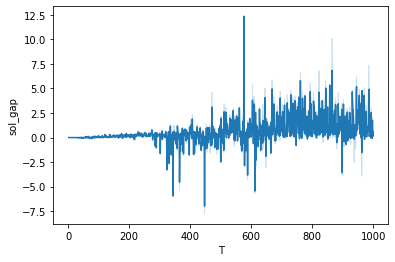

In [181]:
sns.lineplot(data=base, x="T", y="sol_gap", ci=36)#, style='nil_nil')

In [171]:
cat_params = []
for var in params:
    test[var + '_cat'] = pd.cut(test[var], 20)
    cat_params.append(var + '_cat')

In [172]:
formula = 'y ~ ' + ' + '.join(cat_params)

mod1 = smf.glm(formula=formula, data=test, family=sm.families.Binomial()).fit()
test['pred'] = mod1.predict(test)
fpr, tpr, thresholds = metrics.roc_curve(test['y'].astype(int), test['pred'])
print('AUC: ', metrics.auc(fpr, tpr))
mod1.summary()

AUC:  0.8165527816114709


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                10979
Model:                            GLM   Df Residuals:                    10852
Model Family:                Binomial   Df Model:                          126
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5682.2
Date:                Sun, 23 Oct 2022   Deviance:                       11364.
Time:                        08:26:55   Pearson chi2:                 1.06e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2936
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               6.5741      0.338     19.478      0.000       5.913       7.236
T_cat[T.Interval(51.85, 101.7, closed='right')]        -2.6870      0.217    -12.366      0.000      -3.113      -2.261
T_cat[T.Interval(101.7, 151.55, closed='right')]       -3.6446      0.217    -16.810      0.000      -4.070      -3.220
T_cat[T.Interval(151.55, 201.4, closed='right')]       -4.3227      0.223    -19.412      0.000      -4.759      -3.886
T_cat[T.Interval(201.4, 251.25, closed='right')]       -4.6232      0.222    -20.866      0.000      -5.057      -4.189
T_cat[T.Interval(251.25, 301.1, closed='right')]       -4.7548      0.223    -21.308      0.000      -5.192      -4.317
T_cat[T.Interval(301.1, 350.95, closed='right')]       -4.3720      0.219    -19.963      0.000      -4.801      -3.943
T_cat[T.Interval(350.95, 400.8, closed='right')]       -4.4901      0.221    -20.319      0.000      -4.923      -4.057
T_cat[T.Interval(400.8, 450.65, closed='right')]       -4.2038      0.219    -19.229      0.000      -4.632      -3.775
T_cat[T.Interval(450.65, 500.5, closed='right')]       -4.0038      0.217    -18.447      0.000      -4.429      -3.578
T_cat[T.Interval(500.5, 550.35, closed='right')]       -3.9632      0.217    -18.249      0.000      -4.389      -3.538
T_cat[T.Interval(550.35, 600.2, closed='right')]       -3.6471      0.217    -16.808      0.000      -4.072      -3.222
T_cat[T.Interval(600.2, 650.05, closed='right')]       -3.5182      0.218    -16.173      0.000      -3.945      -3.092
T_cat[T.Interval(650.05, 699.9, closed='right')]       -3.5355      0.215    -16.439      0.000      -3.957      -3.114
T_cat[T.Interval(699.9, 749.75, closed='right')]       -3.3586      0.216    -15.532      0.000      -3.782      -2.935
T_cat[T.Interval(749.75, 799.6, closed='right')]       -3.2111      0.215    -14.942      0.000      -3.632      -2.790
T_cat[T.Interval(799.6, 849.45, closed='right')]       -3.1412      0.217    -14.484      0.000      -3.566      -2.716
T_cat[T.Interval(849.45, 899.3, closed='right')]       -2.9390      0.212    -13.841      0.000      -3.355      -2.523
T_cat[T.Interval(899.3, 949.15, closed='right')]       -2.6925      0.217    -12.384      0.000      -3.119      -2.266
T_cat[T.Interval(949.15, 999.0, closed='right')]       -2.6392      0.215    -12.303      0.000      -3.060      -2.219
d_11_cat[T.Interval(0.0125, 0.025, closed='right')]    -0.3913      0.145     -2.707      0.007      -0.675      -0.108
d_11_cat[T.Interval(0.025, 0.0375, closed='right')]    -0.4178      0.144     -2.898      0.004      -0.700      -0.135
d_11_cat[T.Interval(0.0375, 0.05, closed='right')]     -0.5857      0.149     -3.92

In [156]:
0.91*2-1

0.8200000000000001

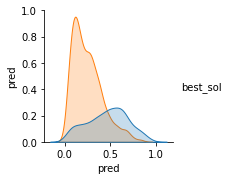

In [132]:

sns.pairplot(test[['best_sol', 'pred']], hue='best_sol')

In [10]:
hm_test = base.query('cost_sol_gov > cost_sol & msg_sol_gov == "found solution"')
hm_test.set_index(['d_11', 'd_12'], inplace=True)

In [20]:
sns.heatmap(test.query('best_sol=="game"').drop('best_sol', axis=1))

ValueError: could not convert string to float: 'd_11'

In [37]:
base.query('cost_sol > cost_sol_gov')[['d_11', 'd_12', 'd_21', 'd_22']].sum(axis=1).mean()

0.5352548689346586

In [38]:
base.query('cost_sol < cost_sol_gov')[['d_11', 'd_12', 'd_21', 'd_22']].sum(axis=1).mean()

0.4258546243229284

In [39]:
base.query('cost_sol > cost_sol_gov').eval('d_12*d_21').mean()

0.018343999469177436

In [40]:
base.query('cost_sol > cost_sol_gov')[['d_11', 'd_22', 'T']].mean()

d_11      0.140039
d_22      0.123119
T       553.483402
dtype: float64

In [41]:
base.query('cost_sol < cost_sol_gov').eval('d_12*d_21').mean()

0.004261639915904168

In [24]:
base

,T,I0,d,l,Recovered_rate,ReSusceptible_rate,time,v_sol,v_der_sol,cost_sol,msg_sol,v_sol_gov,v_der_sol_gov,cost_sol_gov,msg_sol_gov,d_11,d_12,d_21,d_22
0,914,0.037480,"[[0.8565816349272409, 0.6292831855177051], [0....","[50, 2300]",0,0,29.335019,"[[0.13220528342631357, 0.8116401933875722], [0...","[[4.804618924936221e-10, -8.510906290837283e-0...",591.848974,found solution,"[[0.062481132833233526, 0.062481132833233526],...","[[-239.78417793861823, -250.21161963344957], [...",316.343050,found solution,0.856582,0.629283,0.483606,0.908240
1,210,0.002814,"[[0.1811095865877227, 0.8615772933961338], [0....","[77, 154]",0,0,3.043460,"[[0.5083858220791662, 0.3974059127194974], [0....","[[-2.7481602327128485e-08, -1.6335377495124703...",22.342767,found solution,"[[0.372188959122877, 0.372188959122877], [0.37...","[[-5.350097044444526, -2.5515503095256253], [-...",20.813578,found solution,0.181110,0.861577,0.150991,0.959984
2,448,0.092969,"[[0.27210870926413344, 0.7953386076766586], [0...","[46, 1702]",0,0,12.776767,"[[0.2179515946389642, 0.7376240890846264], [0....","[[8.363087999896379e-12, -1.2317620257107365e-...",621.799149,found solution,"[[0.08044517647035616, 0.08044517647035616], [...","[[-148.10193159888706, -145.07554906301644], [...",450.403564,found solution,0.272109,0.795339,0.902819,0.237061
3,647,0.072381,"[[0.3221893262459786, 0.9652239563946082], [0....","[38, 798]",0,0,16.529536,"[[0.19676556812392365, 0.513278486087027], [0....","[[7.09370340246096e-11, -2.727185588469183e-09...",328.989947,found solution,"[[0.0889846695016355, 0.0889846695016355], [0....","[[-117.29241219513654, -112.9960958740204], [9...",229.319828,found solution,0.322189,0.965224,0.740347,0.458198
4,458,0.051370,"[[0.9731576326301973, 0.2951818004700274], [0....","[7, 35]",0,0,4.466413,"[[0.23738641299054425, 0.9423493485621331], [0...","[[3.0604496714659035e-10, -5.625146348720023e-...",51.060503,found solution,"[[0.22088180515676975, 0.22088180515676975], [...","[[-7.448328917304595, -18.637151466984033], [-...",39.520211,found solution,0.973158,0.295182,0.260556,0.909412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,792,0.025416,"[[0.8212704864063497, 0.2837052908809725], [0....","[20, 140]",0,0,9.007427,"[[0.18024703769729836, 0.7616229153895309], [0...","[[-4.1801584416134574e-10, -9.296900582711487e...",83.575289,found solution,"[[0.15537822189308395, 0.15537822189308395], [...","[[-24.046523310038427, -38.43112421111843], [-...",58.739820,found solution,0.821270,0.283705,0.229973,0.869230
2948,400,0.017882,"[[0.11898628366519559, 0.45504947518363503], [...","[50, 550]",0,0,2.094115,"[[0.42591439004906206, 0.8562517018068917], [0...","[[-1.509903313490213e-14, 2.042810365310288e-1...",87.958068,found solution,"[[0.22615422669284008, 0.22615422669284008], [...","[[-17.2696117909372, -15.22442606717092], [26....",64.403508,found solution,0.118986,0.455049,0.437304,0.121604
2949,903,0.075246,"[[0.3744280344312455, 0.6485019550454362], [0....","[87, 2088]",0,0,6.991305,"[[0.13164969703267537, 0.3750856223525718], [0...","[[1.4622969501942862e-10, -9.226468478118477e-...",616.322075,found solution,"[[0.06294028947463672, 0.06294028947463672], [...","[[-230.19585838102168, -233.5574628223527], [-...",473.486791,found solution,0.374428,0.648502,0.332261,0.522544
2950,657,0.090897,"[[0.49718973502944186, 0.7011242546638777], [0...","[33, 1551]",0,0,3.632560,"[[0.1684279186438112, 0.716381084588251], [0.0...","[[-2.5579538487363607e-12, 2.311484337269576e-...",622.131160,found solution,"[[0.09970753370066586, 0.09970753370066586], [...","[[-83.46315812720917, -90.22237384507537], [22...",449.958674,found solution,0.497190,0.701124,0.390621,0.036780


In [26]:
base.query('cost_sol < cost_sol_gov')[['d_11', 'd_22', 'T']].mean()

d_11      0.502530
d_22      0.172665
T       567.394737
dtype: float64

In [16]:
base.query('cost_sol < cost_sol_gov').shape

(76, 19)

In [17]:
base.query('cost_sol > cost_sol_gov').shape

(2876, 19)